# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Основные шаги:
1. Загрузите данные, путь к файлу: /datasets/autos.csv.
2. Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.
3. Подготовьте выборки для обучения моделей.
4. Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.
5. Проанализируйте время обучения, время предсказания и качество моделей.
6. Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

Примечания:
- Для оценки качества моделей применяйте метрику RMSE.
- Значение метрики RMSE должно быть меньше 2500.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
- Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.
- Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del.

Признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

## Подготовка данных

In [1]:
# импорты из стандартной библиотеки
import warnings

# импорты сторонних библиотек
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# импорты модулей текущего проекта
from sklearn.compose import make_column_transformer
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    GridSearchCV, 
    #RandomizedSearchCV,
    train_test_split
)

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor 

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    #OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

# настройки
warnings.filterwarnings("ignore")

# константы заглавными буквами
RANDOM_STATE = 12345

In [2]:
#Считываем данные из csv-файла в датафрейм
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

# КОД РЕВЬЮЕРА
INIT_DATA_SIZE = data.shape[0]

In [3]:
#Функция получения первичной информации о датафрейме
def studying_the_data (data):
    print ('------------- Первые 5 строк ------------')
    display(data.head())
    print('')
    print('')
    print ('------------- Типы данных ------------')
    print (data.info())
    print('')
    print('')
    print ('------------- Пропуски ------------')
    count = 0
    for element in data.columns:
        if data[element].isna().sum() > 0: 
            print(element, ' - ', data[element].isna().sum(), 'пропусков')
            count = +1
        if count == 0:
            print(element, 'Пропусков НЕТ')
    print('')
    print('')
    print ('------------- Дубликаты ------------')
    if data.duplicated().sum() > 0:
        print('Дубликатов: ', data.duplicated().sum())
    else:
        print('Дубликатов НЕТ')
    print('')
    print('')
    display(data.describe())

studying_the_data (data)

------------- Первые 5 строк ------------


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 n

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Удалим дубликаты, их всего 4

In [4]:
data.drop_duplicates(inplace=True) 

Удалим столбцы не несущие важной информации: DateCrawled, RegistrationMonth, DateCreated, NumberOfPictures, PostalCode, LastSeen

In [5]:
data = data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


Проведем предобработку оставшихся данных

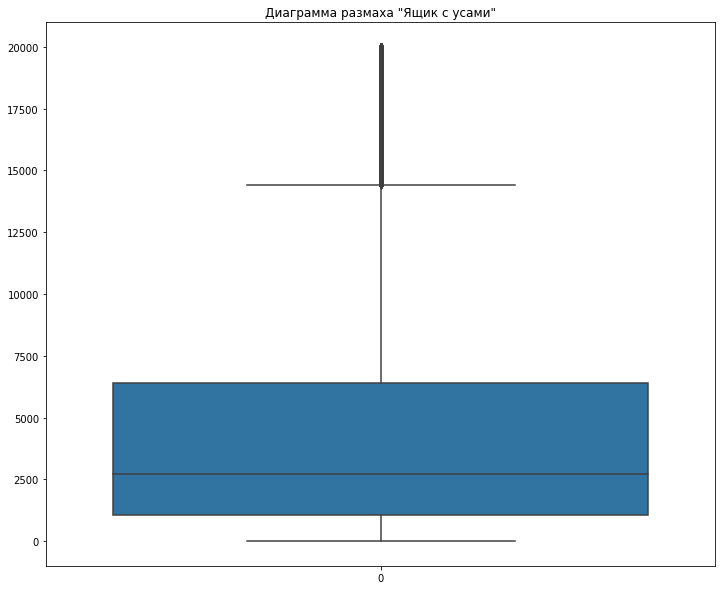

In [6]:
#Построим диаграмму размаха (график «ящик с усами») для Price
plt.figure(figsize=(12,10))
sns.boxplot(data=data['Price'])
plt.title('Диаграмма размаха "Ящик с усами"')
plt.show()

In [7]:
#Посмотрим квантили
data['Price'].quantile([.05, 0.95])

0.05      200.0
0.95    14600.0
Name: Price, dtype: float64

In [8]:
#Исключим данные с ценой меньше 10 и больше 30000
data = data.query('10 <= Price <= 30000')

display(data['Price'].describe())

count    342337.000000
mean       4571.855254
std        4514.902138
min          10.000000
25%        1200.000000
50%        2900.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

In [9]:
#Заменим строки с пропусками Model на Unknown, так как узнать модель мы их не сможем
data['Model'] = data['Model'].fillna('Unknown')

data['Model'].isna().sum()

0

In [10]:
#Заменим пропуски в VehicleType
#data['VehicleType']=data['VehicleType'].fillna(data.groupby(['Brand', 'Model'])['VehicleType'].transform(lambda x:x.mode()[0] if not x.mode().empty else "unknown"))
#Для этого напишем функцию  
def fill_na(column, column1, column2):
    data[column]=data[column].fillna(data.groupby([column1, column2])[column].transform(lambda x:x.mode()[0] if not x.mode().empty else "unknown"))

In [11]:
#Заменим пропуски в VehicleType
fill_na('VehicleType', 'Brand', 'Model')

data['VehicleType'].isna().sum()

0

In [12]:
#Заменим строки с пропусками Gearbox на Unknown, так как узнать тип коробки передач мы не сможем
data['Gearbox'] = data['Gearbox'].fillna('Unknown')

data['Gearbox'].isna().sum()

0

In [13]:
#Заменим пропуски в FuelType
fill_na('FuelType', 'Brand', 'Model')

data['FuelType'].isna().sum()

0

In [14]:
#Заменим строки с пропусками Repaired на Unknown, так как узнать был ремонт или нет мы не сможем
data['Repaired'] = data['Repaired'].fillna('Unknown')

data['Repaired'].isna().sum()

0

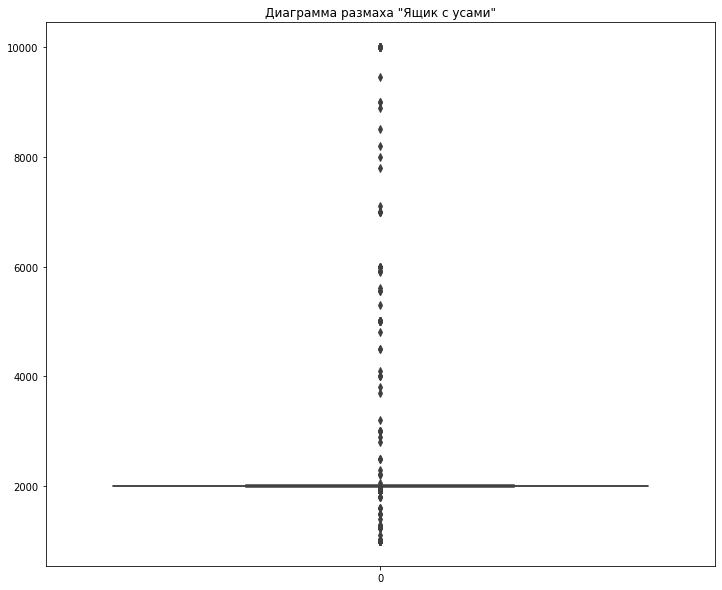

In [15]:
#Построим диаграмму размаха (график «ящик с усами») для RegistrationYear
plt.figure(figsize=(12,10))
sns.boxplot(data=data['RegistrationYear'])
plt.title('Диаграмма размаха "Ящик с усами"')
plt.show()

In [16]:
#Посмотрим квантили
data['RegistrationYear'].quantile([.05, 0.95])

0.05    1993.0
0.95    2016.0
Name: RegistrationYear, dtype: float64

In [17]:
#Исключим данные с годами меньше 1920 и больше 2016
data = data.query('1920 <= RegistrationYear <= 2016')

display(data['RegistrationYear'].describe())

count    328532.000000
mean       2002.621790
std           6.807305
min        1923.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

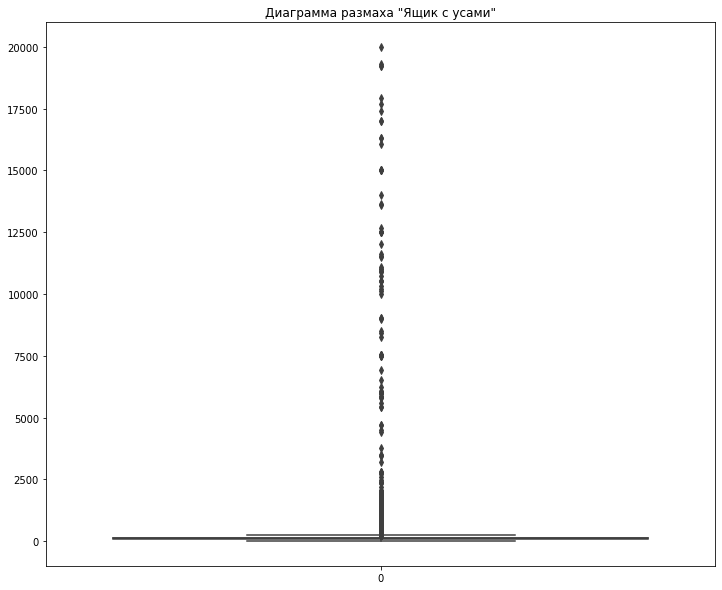

In [18]:
#Построим диаграмму размаха (график «ящик с усами») для Power
plt.figure(figsize=(12,10))
sns.boxplot(data=data['Power'])
plt.title('Диаграмма размаха "Ящик с усами"')
plt.show()

<AxesSubplot:>

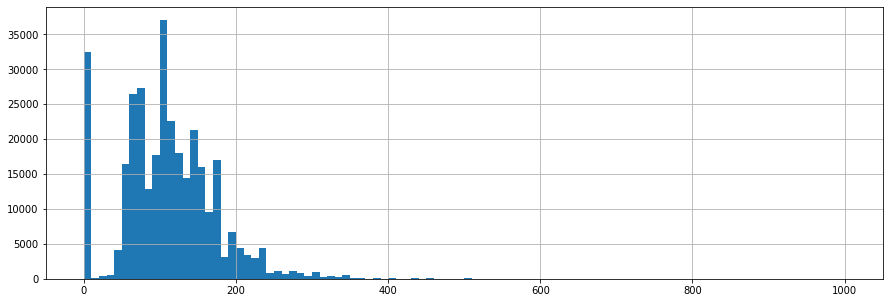

In [19]:
#Построим гистрограмму Power
data['Power'].hist(bins=100, range=(0, 1000), figsize=(15,5))

In [20]:
#Посмотрим квантили
data['Power'].quantile([.05, 0.95])

0.05      0.0
0.95    218.0
Name: Power, dtype: float64

In [21]:
#Исключим данные с мощностью 0 и больше 700
data = data.query('0 < Power <= 700')

display(data['Power'].describe())

count    295910.000000
mean        120.615701
std          54.115699
min           1.000000
25%          75.000000
50%         111.000000
75%         150.000000
max         700.000000
Name: Power, dtype: float64

In [22]:
# КОД РЕВЬЮЕРА
data.shape[0] / 354369

0.8350335384867187

### Вывод
1. Удалили явные дубликаты
2. Удалили столбцы не несущие важной информации: DateCrawled, RegistrationMonth, DateCreated, NumberOfPictures, PostalCode, LastSeen
3. Исключили пропуски заменяя/удаляя
4. Удалили выбросы

## Обучение моделей

In [23]:
#Категориальные признаки
oe_data_linear = data.select_dtypes(include='object').columns.to_list()
print(oe_data_linear)

#Численные признаки
num_scaler = data.select_dtypes(exclude='object').columns.to_list()
num_scaler.remove('Price')
num_scaler

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']


['RegistrationYear', 'Power', 'Kilometer']

Выделим целевые признаки.

In [24]:
target = data[['Price']]
features = data.drop(['Price'], axis=1)

Разделим исходные данные на обучающую и тестовую выборки.

In [25]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345
)

#features_train_valid, features_test_valid, target_train_valid, target_test_valid = train_test_split(
#    features_test, target_test, test_size=0.5, random_state=12345)

print(features_train.shape[0])
print(target_train.shape[0])
print(features_test.shape[0])
print(target_test.shape[0])

221932
221932
73978
73978


In [26]:
features_train_orig = features_train.copy()
target_train_orig = features_test.copy()

Проведем кодирование используя OrdinalEncoder

In [27]:
#encoder = OrdinalEncoder(dtype=np.int16)
#encoder.fit(data[oe_data_linear])
#data[oe_data_linear] = encoder.transform(data[oe_data_linear])
#data = data.astype(np.int16)
#data.info()

def ordinal_encoder(train, test):
    encoder = OrdinalEncoder(dtype=np.int16)
    encoder.fit(train[oe_data_linear])
    train[oe_data_linear] = encoder.transform(train[oe_data_linear])
    test[oe_data_linear] = encoder.transform(test[oe_data_linear])
    train = train.astype(np.int16)
    
ordinal_encoder(features_train, features_test)

Стандартизируем признаки используя StandardScaler

In [28]:
def scale_to_standard(train, test):
    scaler = StandardScaler()
    scaler.fit(train[num_scaler])
    train[num_scaler] = scaler.transform(train[num_scaler])
    test[num_scaler] = scaler.transform(test[num_scaler])

scale_to_standard(features_train, features_test)

~Обозначим категориальные и числовые признаки~

In [29]:
#Категориальные признаки для OHE linear
#ohe_features_linear = features_train.select_dtypes(include='object').columns.to_list()
#print(ohe_features_linear)

#Категориальные признаки для OHE RandomForestRegressor
#ohe_features_rf = ohe_features_linear.copy()
#ohe_features_rf.remove('Model')
#ohe_features_rf

In [30]:
#Численные признаки
#num_features = features_train.select_dtypes(exclude='object').columns.to_list()
#num_features.remove('Repaired')
#num_features

~Проведем кодирование и масштабирование используя make_column_transformer~

In [31]:
#features_train_linear = features_train.copy()
#features_test_linear = features_test.copy()

In [32]:
# Признак repaired уже бинарный, его не будем кодировать/масштабировать
# добавляем remainder='passthrough, чтобы он не пропал 
#col_transformer_linear = make_column_transformer(
#    (
#        OneHotEncoder(drop='first', handle_unknown='ignore'),
#        ohe_features_linear
#    ),
#    (
#        StandardScaler(), 
#        num_features
#    ),
#    remainder='passthrough',
#)

#features_train_ridge = pd.DataFrame.sparse.from_spmatrix(
#    col_transformer_ridge.fit_transform(features_train_ridge),
#    columns=col_transformer_ridge.get_feature_names_out()
#)

#Смотрим на результат
#features_train_ridge.head()

~Будем использовать pipeline~

In [33]:
#model_linear = LinearRegression

#pipeline_linear = make_pipeline(col_transformer_linear, model_linear(n_jobs=-1))

#param_grid_linear = {
#    'linearregression__normalize':[False, True],
#}

#gs_linear_pl = GridSearchCV(
#    pipeline_linear,
#    param_grid=param_grid_linear,
#    scoring='neg_root_mean_squared_error',
#    n_jobs=-1,
#    verbose=1
#)

#gs_linear_pl.fit(features_train_linear, features_train)

#gs_linear_best_score = gs_linear_pl.best_score_ * -1
#gs_linear_best_params = gs_linear_pl.best_params_

# лучшее значение RMSE на кросс-валидации
#print(f'best_score: {gs_linear_best_score}')
# лучшие гиперпараметры
#print(f'best_params: {gs_linear_best_params}')

In [34]:
#features_train_rf = features_train.copy()
#features_test_rf = features_test.copy()

In [35]:
#col_transformer_rf= make_column_transformer(
#    (
#        OneHotEncoder(drop='first', handle_unknown='ignore'), 
#        ohe_features_rf
#    ),
#    (
#        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
#        ['Model']
#    ),
#    (
#        StandardScaler(), 
#        num_features
#    ),
#    remainder='passthrough'
#)

#model_rf = RandomForestRegressor(random_state=RANDOM_STATE)

#pipline_rf = make_pipeline(col_transformer_rf, model_rf)

#param_grid_rf = {
#    'randomforestregressor__n_estimators': range(50, 251, 50),
#    'randomforestregressor__max_depth': range(2, 15),
#    'randomforestregressor__min_samples_split': (2, 3, 4),
#    'randomforestregressor__min_samples_leaf': (1, 2, 3, 4)
#}

# получается достаточно много комбинаций гиперпараметров при переборе
# будем использовать RandomizedSearchCV, он работает на много быстрее
#gs_rf = RandomizedSearchCV(
#    pipline_rf, 
#    param_distributions=param_grid_rf, 
#    scoring='neg_root_mean_squared_error', 
#    n_jobs=-1, 
#    random_state=RANDOM_STATE
#)

#gs_rf.fit(features_train_rf, features_train)

#gs_rf_best_score = gs_rf.best_score_ * -1
#gs_rf_best_params = gs_rf.best_params_
#print(f'best_score: {gs_rf_best_score}')
#print(f'best_params: {gs_rf_best_params}')

### LGBMRegressor

In [36]:
%%time

model_lgbm = LGBMRegressor()

params_grid_lgbm = {
    #'random_state' : [12345],
    #'n_estimators' : [200, 500, 700],
    #'max_depth' : [20, 30, 40],
    #'num_leaves' : [120, 150, 200],
    #'learning_rate':[0.05, 0.1, 0.3]
    
    'boosting_type':['gbdt'],
    'num_leaves':[31],
    'max_depth':[-1],
    'learning_rate':[0.1],
    'n_estimators':[100],
    'objective':['regression'], # The default is two categories
    'min_split_gain':[0.0],
    'min_child_samples':[20],
    'subsample':[1.0],
    'subsample_freq':[0],
    'colsample_bytree':[1.0],
    'reg_alpha':[0.0],
    'reg_lambda':[0.0],
    'random_state':[None],
    'silent':[True]
}        

#grid_cv = GridSearchCV(estimator=model_lgbm, param_grid=params_grid_lgbm, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
#grid_cv.fit(features_train, target_train, categorical_feature=oe_data_linear)
#print('Лучшие параметры: ', grid_cv.best_params_)
#print('RMSE значение на тренеровочной выборке: {:.2f}'.format((-grid_cv.best_score_) ** 0.5))

Лучшие параметры:  {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_split_gain': 0.0, 'n_estimators': 100, 'num_leaves': 31, 'objective': 'regression', 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_freq': 0}
RMSE значение на тренеровочной выборке: 1613.74
CPU times: user 5min 59s, sys: 2.02 s, total: 6min 1s
Wall time: 6min 4s


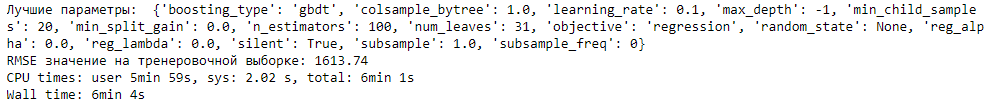

**Примечание.** Если запускать с подбором параметров, то не могу дождаться результата. 

### CatBoost

In [37]:
%%time

model_cat = CatBoostRegressor()
params_grid_cat = {
    'n_estimators' : [50, 100],
    'verbose' : [0],
    'random_state' : [RANDOM_STATE],
    'max_depth' : [5, 7, 10]
}

grid_cv = GridSearchCV(estimator=model_cat, param_grid=params_grid_cat, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_cv.fit(features_train, target_train, cat_features=oe_data_linear, verbose=10)
print('Лучшие параметры: ', grid_cv.best_params_)
print('RMSE значение на тренеровочной выборке: {:.2f}'.format((-grid_cv.best_score_) ** 0.5))

Learning rate set to 0.5
0:	learn: 3304.6001328	total: 119ms	remaining: 5.85s
10:	learn: 1923.3302797	total: 664ms	remaining: 2.35s
20:	learn: 1833.5742058	total: 1.17s	remaining: 1.61s
30:	learn: 1782.5654242	total: 1.65s	remaining: 1.01s
40:	learn: 1752.9111712	total: 2.14s	remaining: 470ms
49:	learn: 1731.3458776	total: 2.58s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3348.4323108	total: 71.6ms	remaining: 3.51s
10:	learn: 1918.9905953	total: 655ms	remaining: 2.32s
20:	learn: 1835.7013812	total: 1.19s	remaining: 1.64s
30:	learn: 1784.9704313	total: 1.72s	remaining: 1.06s
40:	learn: 1746.6728296	total: 2.24s	remaining: 493ms
49:	learn: 1725.7129368	total: 2.71s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3357.7047773	total: 68.3ms	remaining: 3.35s
10:	learn: 1925.6800777	total: 646ms	remaining: 2.29s
20:	learn: 1827.1709640	total: 1.14s	remaining: 1.57s
30:	learn: 1785.8369688	total: 1.64s	remaining: 1s
40:	learn: 1756.3381366	total: 2.12s	remaining: 466ms
49:	learn: 1724

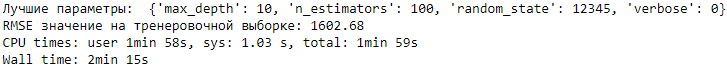

### RandomForestRegressor

In [38]:
%%time

#model_lr = LinearRegression()
model_rfr = RandomForestRegressor(max_depth=10, random_state=RANDOM_STATE)
model_rfr.fit(features_train, target_train)
target_predict = model_rfr.predict(features_train)
rmse_rfr = mean_squared_error(target_train, target_predict) ** .5
print('RMSE значение на тренеровочной выборке: ', rmse_rfr)

RMSE значение на тренеровочной выборке:  1798.7583701497547
CPU times: user 33 s, sys: 119 ms, total: 33.1 s
Wall time: 33.1 s


### Вывод. Получили следующие реузультаты:
1. LGBMRegressor. RMSE значение на тренеровочной выборке: 1613.74 Wall time: 6min 4s
2. CatBoost. RMSE значение на тренеровочной выборке: 1602.68. Wall time: 2min 15s
3. RandomForestRegressor. RMSE значение на тренеровочной выборке:  1798.76. Wall time: 33.1 s

## Анализ моделей

Лучший результат показала CatBoost. RMSE значение на тренеровочной выборке: 1602.68. Wall time: 2min 15s

Проверим лучшую модель на тестовой выборке.

In [44]:
%%time

model_cat = CatBoostRegressor(n_estimators=100, verbose=0, random_state=RANDOM_STATE, max_depth=10)
model_cat.fit(features_test, target_test)
target_predict = model_cat.predict(features_test)
rsme_cat = mean_squared_error(target_test, target_predict) ** 0.5
print('RMSE значение на тестовой выборке: ', rsme_cat)

RMSE значение на тестовой выборке:  1357.5233206787018
CPU times: user 2.59 s, sys: 23.8 ms, total: 2.61 s
Wall time: 3.12 s


Проверка на тестовой выборке показала хороший результат

### Вывод
Построили три модели: LGBMRegressor, CatBoost, RandomForestRegressor.

Результаты:
1. LGBMRegressor. RMSE значение на тренеровочной выборке: 1613.74 Wall time: 6min 4s
2. CatBoost. RMSE значение на тренеровочной выборке: 1602.68. Wall time: 2min 15s
3. RandomForestRegressor. RMSE значение на тренеровочной выборке: 1798.76. Wall time: 33.1 s

Лучшую модель выбрали CatBoost с RMSE 1602.68. 

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей